In [1]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt

e:\Installation\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\Installation\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [31]:
# read an excel file and return a dataframe
def read_excel(file):
    df = pd.read_excel(file)
    return df

df = read_excel('test_dir/lstm_dmc.xlsx')

In [32]:
df.head()

,Date,Affected
0,2019/09/01,92.0
1,2019/09/02,82.0
2,2019/09/03,64.0
3,2019/09/04,47.0
4,2019/09/05,63.0


In [36]:
df.shape

(687, 2)

In [34]:
# convert Date field to float
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype(float)

In [35]:
# delete rows where the value of the df['Affected'] is null
df = df[df['Affected'].notnull()]

In [37]:
def create_time_series_samples(df, window_size):
    samples = []
    target_column = df.columns[-1]  # Assuming the target variable is in the last column

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

# Example usage:
# Assuming 'df' is your DataFrame with 10 columns and 383 rows
window_size = 10
samples = create_time_series_samples(df, window_size)

In [56]:
#Take the first sample and run LSTM model of Pytorch on that...here first 9 rows will be training set, last row will be test set... last column is y and other colimns are X..find prediction on test set

#Take the first sample
sample = samples[0]

# last column is y and other colimns are X
X = sample.iloc[:, :-1] 
y = sample.iloc[:, -1]

# Split into train and test
X_train = X.iloc[:-1, :]
y_train = y.iloc[:-1]
X_test = X.iloc[-1, :]
y_test = y.iloc[-1]

# print(X_train)
# print(y_train)
# print(X_test)
print(y_test)


49.0


In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable


In [42]:
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

predictions_list = []
losses = []

for sample in samples:
    #  features (X) and target variable (y)
    X = sample.iloc[:, :-1]
    y = sample.iloc[:, -1]

    X = X.values
    y = y.values

    # first 9 rows are training data, last row is test data
    X_train = X[:-1]
    y_train = y[:-1]
    X_test = X[-1:]
    y_test = y[-1:]

    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # print(X_train_reshaped.shape)
    # print(X_test_reshaped.shape)
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_reshaped)  # Assuming X_train_reshaped is already defined
    y_train_tensor = torch.FloatTensor(y_train)

    X_test_tensor = torch.FloatTensor(X_test_reshaped)  # Assuming X_test_reshaped is already defined
    y_test_tensor = torch.FloatTensor(y_test)

    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the LSTM model
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers=1):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, 1)  # Output layer with 1 unit for regression tasks

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out[:, -1, :])  # Take the output from the last time step
            return out

    # Initialize the model
    input_size = X_train_tensor.shape[2]  # Number of features
    hidden_size = 50 # Number of features in hidden state
    num_layers = 50 # Number of stacked LSTM layers

    model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

    # the loss function and the optimizer
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate of 0.001

    # Training the model
    num_epochs = 500
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad() # Clear the gradients from previous iteration
            outputs = model(inputs) 
            loss = criterion(outputs.squeeze(), targets) # squeeze() is needed to match dimensions
            loss.backward()
            optimizer.step()

        # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
        # print(f'Test Loss: {test_loss.item():.4f}')

    # Make predictions on the test set
    predictions = test_outputs.numpy()
    predictions_list.append(predictions)
    losses.append(test_loss.item())
    

e:\Installation\Anaconda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
e:\Installation\Anaconda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
e:\Installation\Anaconda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, 

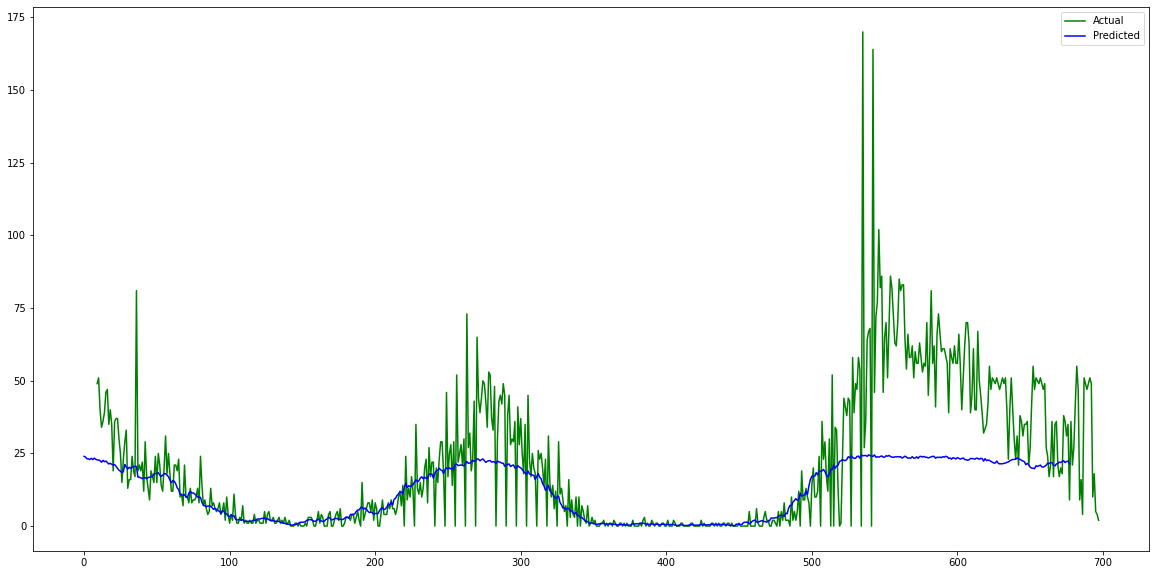

In [49]:
preds = np.array(predictions_list)
preds = preds.squeeze()

plt.figure(figsize=(20, 10))
# plt.plot(df['Affected'], label='Actual')
plt.plot(df['Affected'].iloc[9:], label='Actual',color='green')
plt.plot(preds, label='Predicted',color='blue')
plt.legend()
plt.show()

In [50]:
preds.shape

(678,)

In [51]:
df['Affected'].iloc[9:].shape

(678,)

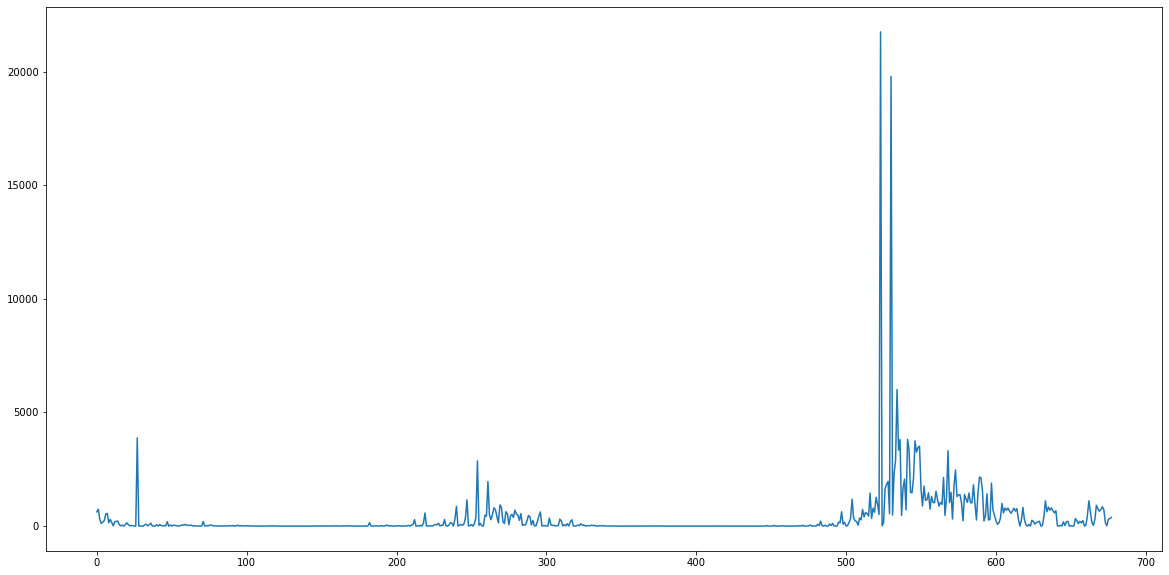

In [45]:
# plot the losses
plt.figure(figsize=(20,10))
plt.plot(losses)
plt.show()

In [12]:
#

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming X and y are already defined and split into training and testing sets

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_reshaped)  # Assuming X_train_reshaped is already defined
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test_reshaped)  # Assuming X_test_reshaped is already defined
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer with 1 unit for regression tasks

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Initialize the model
input_size = X_train_tensor.shape[2]  # Number of features
hidden_size = 50
num_layers = 1

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

# Make predictions on the test set
predictions = test_outputs.numpy()

# You can now use 'predictions' for further analysis or visualization


Epoch [1/10], Loss: 2.2006
Epoch [2/10], Loss: 2.1843
Epoch [3/10], Loss: 2.1681
Epoch [4/10], Loss: 2.1521
Epoch [5/10], Loss: 2.1362
Epoch [6/10], Loss: 2.1204
Epoch [7/10], Loss: 2.1048
Epoch [8/10], Loss: 2.0893
Epoch [9/10], Loss: 2.0739
Epoch [10/10], Loss: 2.0585
Test Loss: 0.9606


e:\Installation\Anaconda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [14]:

# run lstm model on the first sample
# Hyper Parameters
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1
batch_size = 1
num_epochs = 100
learning_rate = 0.01

# LSTM Model
model = nn.LSTM(input_size=1, hidden_size=2, num_layers=1, batch_first=True)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# train the model
# Train the Model
for epoch in range(num_epochs):
    # Convert numpy array to torch Variable
    inputs = Variable(torch.from_numpy(X_train.values).float())
    targets = Variable(torch.from_numpy(y_train.values).float())

    # Forward + Backward + Optimize for input_size 1
    optimizer.zero_grad()  # zero the gradient buffer
    outputs, _ = model(inputs)
    loss = criterion(outputs[:, -1], targets)
    loss.backward()
    optimizer.step()

    print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, loss.data))


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:


# make it a function

def run_lstm_model(sample):
    # last column is y and other colimns are X
    X = sample.iloc[:, :-1]
    y = sample.iloc[:, -1]

    # Split into train and test
    X_train = X.iloc[:-1, :]
    y_train = y.iloc[:-1]
    X_test = X.iloc[-1, :]
    y_test = y.iloc[-1]

    # Hyper Parameters
    input_size = 1
    hidden_size = 2
    num_layers = 1
    num_classes = 1
    batch_size = 1
    num_epochs = 100
    learning_rate = 0.01

    # LSTM Model
    model = nn.LSTM(input_size=1, hidden_size=2, num_layers=1, batch_first=True)

    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # train the model
    # Train the Model
    for epoch in range(num_epochs):
        # Convert numpy array to torch Variable
        inputs = Variable(torch.from_numpy(X_train.values).float())
        targets = Variable(torch.from_numpy(y_train.values).float())

        # Forward + Backward + Optimize for input_size 1
        optimizer.zero_grad()  # zero the gradient buffer
        outputs, _ = model(inputs)
        loss = criterion(outputs[:, -1], targets)
        loss.backward()
        optimizer.step()

        print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, loss.data))

    # Test the Model
    # make 
    inputs = Variable(torch.from_numpy(X_test.values).float())
    targets = Variable(torch.from_numpy(y_test.values).float())
    outputs, _ = model(inputs)
    loss = criterion(outputs[:, -1], targets)
    print('Test Loss: %.4f' % (loss.data))

    # Plot the graph
    predicted = outputs.data.numpy()
    plt.plot(y_test.values, label='True Data')
    plt.plot(predicted, label='Predicted Data')
    plt.legend()
    plt.show()

    return predicted

# run lstm model on the first sample
# Take the first sample
sample = samples[0]
predicted = run_lstm_model(sample)

Epoch [1/100], Loss: 4393.0000
Epoch [2/100], Loss: 4393.0000
Epoch [3/100], Loss: 4393.0000
Epoch [4/100], Loss: 4393.0000
Epoch [5/100], Loss: 4393.0000
Epoch [6/100], Loss: 4393.0000
Epoch [7/100], Loss: 4393.0000
Epoch [8/100], Loss: 4393.0000
Epoch [9/100], Loss: 4393.0000
Epoch [10/100], Loss: 4393.0000
Epoch [11/100], Loss: 4393.0000
Epoch [12/100], Loss: 4393.0000
Epoch [13/100], Loss: 4393.0000
Epoch [14/100], Loss: 4393.0000
Epoch [15/100], Loss: 4393.0000
Epoch [16/100], Loss: 4393.0000
Epoch [17/100], Loss: 4393.0000
Epoch [18/100], Loss: 4393.0000
Epoch [19/100], Loss: 4393.0000
Epoch [20/100], Loss: 4393.0000
Epoch [21/100], Loss: 4393.0000
Epoch [22/100], Loss: 4393.0000
Epoch [23/100], Loss: 4393.0000
Epoch [24/100], Loss: 4393.0000
Epoch [25/100], Loss: 4393.0000
Epoch [26/100], Loss: 4393.0000
Epoch [27/100], Loss: 4393.0000
Epoch [28/100], Loss: 4393.0000
Epoch [29/100], Loss: 4393.0000
Epoch [30/100], Loss: 4393.0000
Epoch [31/100], Loss: 4393.0000
Epoch [32/100], L

AttributeError: 'numpy.int64' object has no attribute 'values'

In [ ]:
# make above two cells a function and run it on all samples
